## Import

In [ ]:
!pip install pytz > /dev/null
!pip install pymysql > /dev/null

In [51]:
import json
import pymysql
from IPython.display import display, Javascript, Image, Audio
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import time
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
from glob import glob
import IPython
from IPython.core.display import display
from pytz import timezone
from datetime import datetime
import os
import sys
import requests
import time
import datetime as dt
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 함수 정의

### 이미지 처리 관련함수

#### yolonet()

In [79]:
def yolonet():
    weight_file = '/content/drive/MyDrive/최종프로젝트/자료/final/yolov3_training_5classes.weights'
    cfg_file = '/content/drive/MyDrive/최종프로젝트/자료/final/yolov3_testing.cfg'

    min_confidence = 0.5
    # Load Yolo
    net = cv2.dnn.readNet(weight_file, cfg_file)
    return(net)

#### yoloimg : 객체 검출 후 데이터프레임으로 만들어주는 함수

In [80]:
def yoloimg(imgfile, net):
    name_file = '/content/drive/MyDrive/최종프로젝트/자료/final/obj.names'

    min_confidence = 0.5

    with open(name_file, 'r') as f:
        classes = [line.strip() for line in f.readlines()]
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    colors = np.random.uniform(0, 255, size=(len(classes), 3))

    # 이미지 가져오기
    img = imgfile
    # img = cv2.resize(img, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape
    # Detecting objects
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)
    # 정보를 화면에 표시
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                # 좌표
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    font = cv2.FONT_HERSHEY_PLAIN

    # 객체 인식 이미지 출력
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        # if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[i]
            # cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y + 30), font, 3, color, 3)

    from google.colab.patches import cv2_imshow
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # 각 Class의 개수를 센 후 df에 넣어줌.
    countid = []
    for i in range(5):
        countid.append(class_ids.count(i))
    # jpgname = imgfile.split('/')[-1].split('.')[0]
    # df = pd.DataFrame({'jpgname':jpgname, 'Person':countid[0], 'Vest':countid[1], 'Helmet' : countid[2], 'NoHelmet' : countid[3], 'NoVest':countid[4]},  index=[0])
    df = pd.DataFrame({'Person':countid[0], 'Vest':countid[1], 'Helmet' : countid[2], 'NoHelmet' : countid[3], 'NoVest':countid[4]},  index=[0])
    return(df)

#### beep() : 출력 음성 관련된 함수

In [81]:
## 함수 안에서는 Ipython의 Audio가 작동을 안해서 이것 저것 찾다보니 나온 임시방편 해결책.... 각각 함수화 시켜서 하면 소리가 잘 나더라고요
def beep0():
    display(Audio("/content/drive/MyDrive/최종프로젝트/코드/음성출력/한명만_서주세요.mp3", autoplay=True))
def beep1():
    display(Audio("/content/drive/MyDrive/최종프로젝트/코드/음성출력/정상입니다.mp3", autoplay=True))
def beep2():
    display(Audio("/content/drive/MyDrive/최종프로젝트/코드/음성출력/헬멧_미착용입니다.mp3", autoplay=True))
def beep3():
    display(Audio("/content/drive/MyDrive/최종프로젝트/코드/음성출력/조끼_미착용입니다.mp3", autoplay=True))
def beep4():
    display(Audio("/content/drive/MyDrive/최종프로젝트/코드/음성출력/다시_서주세요.mp3", autoplay=True)) 
def beepRe():
    display(Audio("/content/drive/MyDrive/최종프로젝트/코드/음성출력/발자국_위에_서주세요.mp3", autoplay=True)) 

#### audioout(df) : 데이터프레임의 값에 따라 beep 음성을 출력

In [82]:
def audioout(df):
    if df.Person[0] >= 2:
        beep0()
    elif df.Person[0] == 1 and df.Helmet[0] == 1 and df.Vest[0]==1:
        beep1()
    elif df.Person[0] == 1 and df.Helmet[0] == 0 and df.Vest[0]==1:
        beep2()
    elif df.Person[0] == 1 and df.Helmet[0] == 1 and df.Vest[0] == 0:
        beep3()
    elif df.Person[0] == 1 and df.Helmet[0] == 0 and df.Vest[0] == 0:
        beep4()

#### take_photo : 웹캠의 사진을 캡쳐 후 photo.jpg로 저장

In [83]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);


      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

#### clovaOD : 클로바 OD api 호출

In [84]:
def clovaOD(filename):
    client_id = "2ir1oc6imp"
    client_secret = "4FIE6xUWDjlFocSUHZw5MjdX1smM733YzIlwBMxk"
    url = "https://naveropenapi.apigw.ntruss.com/vision-obj/v1/detect"# // 객체 인식
    files = {'image': open(filename, 'rb')}
    headers = {'X-NCP-APIGW-API-KEY-ID': client_id, 'X-NCP-APIGW-API-KEY': client_secret }
    response = requests.post(url,  files=files, headers=headers)
    rescode = response.status_code
    if(rescode==200):
        return(response.text)
    else:
        print("Error Code:" + rescode)

#### clovaperson : ClovaOD가 찾아낸 사람 수 리턴

In [85]:
def clovaperson(filename):
    #0 clova를 통해 OD 실행 후
    clovaresult = eval(clovaOD(filename))

    #1 person의 index값들을 추출하기
    person_index = []
    indexscore = []
    nameList = clovaresult['predictions'][0]['detection_names']
    scorelist = clovaresult['predictions'][0]['detection_scores']
    count = 0
    for i in range(len(nameList)):
        if nameList[i] == 'person':
            person_index.append(i)

    #2 person_index에 맞는 신뢰도를 추출  
    for index in person_index:
        indexscore.append(scorelist[index])

    #3 indexscore에서 점수가 0.90 이상인 것들의 개수를 파악
    for score in indexscore:
        if score >= 0.90:
            count += 1
    return(count)

### sql 관련 함수

#### sql_conn(jsonfile) : sql 서버에 연결

In [86]:
def sql_conn(jsonfile):
    with open(jsonfile) as fp:
        config_str = fp.read()
    config = json.loads(config_str)

    conn = pymysql.connect(
        host = config['host'],
        user = config['user'],
        password = config['password'],
        database = config['database'],
        port = config['port']
    )

    return(conn)

#### sqlCreateTable(conn) : sql에 테이블을 생성
- table name : safety

In [125]:
def sqlCreateTable(conn):
    cur = conn.cursor()
    sql_create_table = '''
        create table if not exists safety1( 
            year int(4) not null, 
            month int(2) not null, 
            day int(2) not null,
            hour int(2) unsigned zerofill,
            minute int(2) unsigned zerofill,
            second int(2) unsigned zerofill,
            Person int(2) not null,
            Vest int(2) not null,
            Helmet int(2) not null,
            NoHelmet int(2) not null,
            NoVest int(2) not null,
            imagepath varchar(80) not null       
        );
    '''

    cur.execute(sql_create_table)

#### insert_sql(df) : sql 테이블에 결과값을 입력

In [127]:
def insert_sql(df, imagepath):
    cur = conn.cursor()
    Person = df.Person[0]
    Vest = df.Vest[0]
    Helmet = df.Helmet[0]
    NoHelmet = df.NoHelmet[0]
    NoVest = df.NoVest[0]
    year = df.year[0]
    month = df.month[0]
    day = df.day[0]
    hour = df.hour[0]
    minute = df.minute[0]
    second = df.second[0]
    insert_code = f'INSERT INTO safety1(year, month, day, hour, minute, second, Person, Vest, Helmet, NoHelmet, NoVest, imagepath) VALUES({year}, {month}, {day}, {hour}, {minute}, {second}, {Person}, {Vest}, {Helmet}, {NoHelmet}, {NoVest}, {str(imagepath)});'
    sql_insert = insert_code
    cur.execute(sql_insert)
    conn.commit()

#### sqltoDF() : sql 데이터를 불러와서 데이터프레임으로 만들기

In [129]:
def sqltoDF():
    sql_select = '''
            SELECT DATE_FORMAT(reg_date, '%Y-%m-%d %H:%i:%s') AS reg_date, year, month, day, hour, minute, second, Person, Vest, Helmet, NoHelmet, NoVest 
                FROM safety1
                ORDER BY reg_date;
    '''

    cur = conn.cursor()
    cur.execute(sql_select)
    rows = cur.fetchall()         # fetchall
    rows
    len(rows)

    years = []
    months = []
    days = []
    hours = []
    minutes = []
    seconds = []
    Persons = []
    Vests = []
    Helmets = []
    NoHelmets = []
    NoVests = []

    for i in range(len(rows)):
        years.append(rows[i][1])
        months.append(rows[i][2])
        days.append(rows[i][3])
        hours.append(rows[i][4])
        minutes.append(rows[i][5])
        seconds.append(rows[i][6])
        Persons.append(rows[i][7])
        Vests.append(rows[i][8])
        Helmets.append(rows[i][9])
        NoHelmets.append(rows[i][10])
        NoVests.append(rows[i][11])

    sqldf = pd.DataFrame(data={'year' : years, 'month' : months, 'day' : days, 'hour' : hours, 'minute' : minutes, 'second' : seconds, 'Person' : Persons, 'Vest' : Vests, 'Helmet' : Helmets, 'NoHelmet' : NoHelmets, 'NoVest' : NoVests})
    return(sqldf)

#### sqlday(Y,M,D) : 원하는 날의 데이터를 불러와서 df로 바꿔주는 함수

In [130]:
def sqlday(Y,M,D):
    sql_select = f'''
            SELECT DATE_FORMAT(reg_date, '%Y-%m-%d %H:%i:%s') AS reg_date, year, month, day, hour, minute, second, Person, Vest, Helmet, NoHelmet, NoVest 
                FROM safety1
                WHERE year = {Y} and month = {M} and day = {D}
                ORDER BY reg_date;'''

    cur = conn.cursor()
    cur.execute(sql_select)
    rows = cur.fetchall()         # fetchall
    rows
    len(rows)

    years = []
    months = []
    days = []
    hours = []
    minutes = []
    seconds = []
    Persons = []
    Vests = []
    Helmets = []
    NoHelmets = []
    NoVests = []

    for i in range(len(rows)):
        years.append(rows[i][1])
        months.append(rows[i][2])
        days.append(rows[i][3])
        hours.append(rows[i][4])
        minutes.append(rows[i][5])
        seconds.append(rows[i][6])
        Persons.append(rows[i][7])
        Vests.append(rows[i][8])
        Helmets.append(rows[i][9])
        NoHelmets.append(rows[i][10])
        NoVests.append(rows[i][11])

    sqlday = pd.DataFrame(data={'year' : years, 'month' : months, 'day' : days, 'hour' : hours, 'minute' : minutes, 'second' : seconds, 'Person' : Persons, 'Vest' : Vests, 'Helmet' : Helmets, 'NoHelmet' : NoHelmets, 'NoVest' : NoVests})
    return(sqlday)

#### sqlweek : 주간 결과 통계

In [91]:
day = dt.datetime(2021, 12, 1)
day_before_7 = day - dt.timedelta(days=7)
day, day_before_7

(datetime.datetime(2021, 12, 1, 0, 0), datetime.datetime(2021, 11, 24, 0, 0))

In [92]:
def sqlweek(Y,M,D):
    day = dt.datetime(Y, M, D)
    day_before_7 = day -dt.timedelta(days=7)
    stringday = f'{day.year}-{day.month}-{day.day}'
    stringbeforeday = f'{day_before_7.year}-{day_before_7.month}-{day_before_7.day}'
    sql_select = f'''
            SELECT DATE_FORMAT(reg_date, '%Y-%m-%d') AS reg_date, year, month, day, hour, minute, second, Person, Vest, Helmet, NoHelmet, NoVest 
                FROM safety1
                WHERE reg_date between {stringbeforeday} and {stringday}
                ORDER BY reg_date;'''

    cur = conn.cursor()
    cur.execute(sql_select)
    rows = cur.fetchall()         # fetchall
    rows
    len(rows)

    years = []
    months = []
    days = []
    hours = []
    minutes = []
    seconds = []
    Persons = []
    Vests = []
    Helmets = []
    NoHelmets = []
    NoVests = []

    for i in range(len(rows)):
        years.append(rows[i][1])
        months.append(rows[i][2])
        days.append(rows[i][3])
        hours.append(rows[i][4])
        minutes.append(rows[i][5])
        seconds.append(rows[i][6])
        Persons.append(rows[i][7])
        Vests.append(rows[i][8])
        Helmets.append(rows[i][9])
        NoHelmets.append(rows[i][10])
        NoVests.append(rows[i][11])

    sqlmonth = pd.DataFrame(data={'year' : years, 'month' : months, 'day' : days, 'hour' : hours, 'minute' : minutes, 'second' : seconds, 'Person' : Persons, 'Vest' : Vests, 'Helmet' : Helmets, 'NoHelmet' : NoHelmets, 'NoVest' : NoVests})
    return(sqlmonth)

#### sqlmonth(Y,M) : 원하는 년, 월의 기록을 데이터프레임화 시킴

In [93]:
def sqlmonth(Y,M):
    sql_select = f'''
            SELECT DATE_FORMAT(reg_date, '%Y-%m-%d %H:%i:%s') AS reg_date, year, month, day, hour, minute, second, Person, Vest, Helmet, NoHelmet, NoVest 
                FROM safety1
                WHERE year = {Y} and month = {M}
                ORDER BY reg_date;'''

    cur = conn.cursor()
    cur.execute(sql_select)
    rows = cur.fetchall()         # fetchall
    rows
    len(rows)

    years = []
    months = []
    days = []
    hours = []
    minutes = []
    seconds = []
    Persons = []
    Vests = []
    Helmets = []
    NoHelmets = []
    NoVests = []

    for i in range(len(rows)):
        years.append(rows[i][1])
        months.append(rows[i][2])
        days.append(rows[i][3])
        hours.append(rows[i][4])
        minutes.append(rows[i][5])
        seconds.append(rows[i][6])
        Persons.append(rows[i][7])
        Vests.append(rows[i][8])
        Helmets.append(rows[i][9])
        NoHelmets.append(rows[i][10])
        NoVests.append(rows[i][11])

    sqlmonth = pd.DataFrame(data={'year' : years, 'month' : months, 'day' : days, 'hour' : hours, 'minute' : minutes, 'second' : seconds, 'Person' : Persons, 'Vest' : Vests, 'Helmet' : Helmets, 'NoHelmet' : NoHelmets, 'NoVest' : NoVests})
    return(sqlmonth)

#### sqlquater(Y) : 주어진 연도의 데이터들을 불러옴

In [94]:
def q4cut(s):
    return pd.qcut(s, 4, labels=["1분기", "2분기", "3분기", "4분기"]).astype(str)

def sqlquater(Y):
    # if Q == 1:
    #     M1 = 1
    #     M2 = 3
    # elif Q == 2:
    #     M1 = 4
    #     M2 = 6        
    # elif Q == 3:
    #     M1 = 7
    #     M2 = 9
    # else:
    #     M1 = 10
    #     M2 = 12

    sql_select = f'''
            SELECT DATE_FORMAT(reg_date, '%Y-%m-%d %H:%i:%s') AS reg_date, year, month, day, hour, minute, second, Person, Vest, Helmet, NoHelmet, NoVest 
                FROM safety1
                WHERE year = {Y}
                ORDER BY reg_date;'''
    cur = conn.cursor()
    cur.execute(sql_select)
    rows = cur.fetchall()         # fetchall
    rows
    len(rows)

    years = []
    months = []
    days = []
    hours = []
    minutes = []
    seconds = []
    Persons = []
    Vests = []
    Helmets = []
    NoHelmets = []
    NoVests = []

    for i in range(len(rows)):
        years.append(rows[i][1])
        months.append(rows[i][2])
        days.append(rows[i][3])
        hours.append(rows[i][4])
        minutes.append(rows[i][5])
        seconds.append(rows[i][6])
        Persons.append(rows[i][7])
        Vests.append(rows[i][8])
        Helmets.append(rows[i][9])
        NoHelmets.append(rows[i][10])
        NoVests.append(rows[i][11])

    sqlquater = pd.DataFrame(data={'year' : years, 'month' : months, 'day' : days, 'hour' : hours, 'minute' : minutes, 'second' : seconds, 'Person' : Persons, 'Vest' : Vests, 'Helmet' : Helmets, 'NoHelmet' : NoHelmets, 'NoVest' : NoVests})
    
    return(sqlquater)


#### sqlimage() : 주어진 연월일시분초에 맞는 사진 출력

In [ ]:
def sqlimage(year,month,day,hour,minute,second):
    sql_select = f'''
            SELECT imagepath, year, month, day, hour, minute, second, Person, Vest, Helmet, NoHelmet, NoVest
                FROM safety1
                WHERE year = {year} and month = {month} and day = {day} and hour = {hour} and minute = {minute} and second = {second}
                '''
    cur = conn.cursor()
    cur.execute(sql_select)
    row = cur.fetchone()         # fetchall
    return(Image.open(row[0]))

#### sqlfindimage() : 입력한 연월일시분초에 맞는 사진 출력


In [ ]:
def sqlfindimage():
    year = input('연도를 입력해주세요 : ')
    month = input('월을 입력해주세요 : ')
    day = input('일을 입력해주세요 : ')
    hour = input('시간을 입력해주세요 : ')
    minute = input('분을 입력해주세요 : ')
    second = input('초를 입력해주세요 : ')
    return(sqlimage(year,month,day,hour,minute,second))

### 데이터 통계 관련 함수

#### cal_hel, cal_vest : 

In [95]:
def cal_hel(row):
  if row.Helmet == row.Person == 0 :               # 1) 헬멧 객체와 사람객체가 0인 경우 미표기
    return None
  else:                                            # 2) 사람 >= 헬멧 인 경우 헬멧/사람*100 으로 착용률 계산
    return row.Helmet / row.Person * 100


def cal_vest(row):
  if row.Vest == row.Person == 0 :                # 1) 조끼 객체와 사람객체가 0인 경우 미표기
    return None
  else:                                           # 2) 사람 >= 조끼 인 경우 조끼/사람*100 으로 착용률 계산
    return row.Vest / row.Person * 100

#### DayResult(Y, M, D) : 원하는 날의 통계를 내고 구글드라이브에 csv 저장
- Ex) (Y,M,D) = (2021,01,01)
- print를 넣어도 되고 안넣어도 되고

In [96]:
def DayResult(Y, M, D):
    df = sqlday(Y, M, D)

    day = dt.datetime(Y, M, D) # today 2021-01-01 가정

    y = day.year
    m = day.month
    d = day.day

    df = df.astype(int)
    df['Person'] =df.apply(lambda row: row['Helmet'] + row['NoHelmet'] if row['Helmet'] + row['NoHelmet'] >= row['Person'] else row['Person'],axis=1)
    df['Person'] =df.apply(lambda row: row['Vest'] + row['NoVest'] if row['Vest'] + row['NoVest'] >= row['Person'] else row['Person'],axis=1) 
    # 전날 시간대별 헬멧/조끼 평균 착용률
    df[['헬멧착용률(%)']] = df.apply(cal_hel, axis=1)
    df[['조끼착용률(%)']] = df.apply(cal_vest, axis=1)
    df.rename(columns = {'year':'연도', 'month':'월', 'day':'일', 'hour':'시간'}, inplace=True)
    df = df[['연도', '월', '일', '시간', '헬멧착용률(%)', '조끼착용률(%)']].groupby(['연도', '월', '일', '시간']).mean().round(1)
    filename = f'df_result_{Y}_{M}_{D}.csv'
    # df.to_csv(f'/content/drive/MyDrive/최종프로젝트/자료/대시보드/{filename}')
    return(df)

#### MonthResult(Y, M) : 주어진 연, 월의 자료를 통계낸 후 저장

In [97]:
def MonthResult(Y, M):
    df = sqlmonth(Y, M).astype(int)
   
    df['Person'] =df.apply(lambda row: row['Helmet'] + row['NoHelmet'] if row['Helmet'] + row['NoHelmet'] >= row['Person'] else row['Person'],axis=1)
    df['Person'] =df.apply(lambda row: row['Vest'] + row['NoVest'] if row['Vest'] + row['NoVest'] >= row['Person'] else row['Person'],axis=1) 
    # 전날 시간대별 헬멧/조끼 평균 착용률
    df[['헬멧착용률(%)']] = df.apply(cal_hel, axis=1)
    df[['조끼착용률(%)']] = df.apply(cal_vest, axis=1)
    df.rename(columns = {'year':'연도', 'month':'월', 'day':'일', 'hour':'시간'}, inplace=True)
    df = df[['연도', '월', '헬멧착용률(%)', '조끼착용률(%)']].groupby(['연도', '월']).mean().round(1)
    filename = f'df_monthresult_{Y}_{M}.csv'
    # df.to_csv(f'/content/drive/MyDrive/최종프로젝트/자료/대시보드/{filename}')
    return(df)

In [98]:
def MonthTimeResult(Y, M):
    df = sqlmonth(Y, M).astype(int)
   
    df['Person'] =df.apply(lambda row: row['Helmet'] + row['NoHelmet'] if row['Helmet'] + row['NoHelmet'] >= row['Person'] else row['Person'],axis=1)
    df['Person'] =df.apply(lambda row: row['Vest'] + row['NoVest'] if row['Vest'] + row['NoVest'] >= row['Person'] else row['Person'],axis=1) 
    # 전날 시간대별 헬멧/조끼 평균 착용률
    df[['헬멧착용률(%)']] = df.apply(cal_hel, axis=1)
    df[['조끼착용률(%)']] = df.apply(cal_vest, axis=1)
    df.rename(columns = {'year':'연도', 'month':'월', 'day':'일', 'hour':'시간'}, inplace=True)
    df = df[['연도', '월', '시간', '헬멧착용률(%)', '조끼착용률(%)']].groupby(['연도', '월',  '시간']).mean().round(1)
    filename = f'df_monthtimeresult_{Y}_{M}.csv'
    # df.to_csv(f'/content/drive/MyDrive/최종프로젝트/자료/대시보드/{filename}')
    return(df)

#### QuaterResult(Y) : 입력한 연도의 분기별 통계 내기

In [99]:
def QuaterResult(Y):
    df = sqlquater(Y).astype(int)
    df["분기"] = df.month.transform(q4cut)
    df['Person'] =df.apply(lambda row: row['Helmet'] + row['NoHelmet'] if row['Helmet'] + row['NoHelmet'] >= row['Person'] else row['Person'],axis=1)
    df['Person'] =df.apply(lambda row: row['Vest'] + row['NoVest'] if row['Vest'] + row['NoVest'] >= row['Person'] else row['Person'],axis=1) 

    df[['헬멧착용률(%)']] = df.apply(cal_hel, axis=1)
    df[['조끼착용률(%)']] = df.apply(cal_vest, axis=1)
    df.rename(columns = {'year':'연도', 'month':'월', 'day':'일', 'hour':'시간'}, inplace=True)
    # 분기별 시간대별 데이터 통계
    df = df[['연도', '분기', '헬멧착용률(%)', '조끼착용률(%)']].groupby(['연도', '분기']).mean().round(1)
    filename = f'df_quaterresult_{Y}.csv'
    # df.to_csv(f'/content/drive/MyDrive/최종프로젝트/자료/대시보드/{filename}')
    return(df)

### 실행함수

In [185]:
def CCTVDetection():
    net = yolonet()
    while True: # 몇번 동작할 것인지.
        if datetime.now(timezone('Asia/Seoul')).hour<18:  # 실제 사용에서는 datetime.now(timezone('Asia/Seoul')).hour < 18 으로 해서 오후 6시 정각까지만 작동하도록 하면 됨
            time.sleep(2)   # 2초 간격으로 캡쳐   # 몇초 단위로 캡쳐할 것인지
            take_photo()
            clovaperson('photo.jpg')
            frame = cv2.imread('photo.jpg') # 캡쳐한 이미지를 openCV형식으로 전환
            df = yoloimg(frame, net)
            today = datetime.now(timezone('Asia/Seoul'))
            df['year'] = today.year
            df['month'] = today.month
            df['day'] = today.day
            hour = (str(today.hour)).zfill(2)
            df['hour'] = hour
            minute= (str(today.minute)).zfill(2)
            df['minute'] = minute
            second = (str(today.second)).zfill(2)
            df['second'] = second
            df['Person'][0] = clovaperson('photo.jpg') # df의 Person을 CLOVA OD가 파악한 사람수로 바꿔주기
            image = Image.open('photo.jpg')
            imagepath1 = f'/content/drive/MyDrive/Data/ProjectF/CCTVImage/CCTVimage_{today.year}{today.month}{today.day}_{hour}{minute}{second}.jpg'
            imagepath2 = f"'/content/drive/MyDrive/Data/ProjectF/CCTVImage/CCTVimage_{today.year}{today.month}{today.day}_{hour}{minute}{second}.jpg'"
            image.save(imagepath1, format='JPEG')
            insert_sql(df,imagepath2)
        else:# 6시 정각 이후에는 멈춤
            break

In [101]:
def EntranceDetection():
    net = yolonet()
    while True: # 몇번 동작할 것인지.
        if datetime.now(timezone('Asia/Seoul')).hour<18:  # 실제 사용에서는 datetime.now(timezone('Asia/Seoul')).hour < 18 으로 해서 오후 6시 정각까지만 작동하도록 하면 됨
            time.sleep(2)   # 2초 간격으로 캡쳐
            take_photo()
            clovaresult = clovaperson('photo.jpg')            
            if clovaresult > 0:  # 사람수가 1 이상일때 > YOLO 진
                beepRe()
                while True:
                    take_photo()
                    clovasecond = clovaperson('photo.jpg')
                    if clovasecond > 0:
                        frame = cv2.imread('photo.jpg') # 캡쳐한 이미지를 openCV형식으로 전환
                        df = yoloimg(frame, net)
                        df['Person'][0] = clovaperson('photo.jpg') # df의 Person을 CLOVA OD가 파악한 사람수로 바꿔주기
                        if df.Person[0] == 1 and df.Helmet[0] == 1 and df.Vest[0]==1:
                            beep1()
                            break
                        else:
                            audioout(df)
                    else:
                        pass
                else:
                    break

        else:
            break

# `**최종프로젝트 순서**`

0. sql 서버에 연결 : conn = sql_conn(jsonfile)</br>
(선택) sql 테이블 생성 : sqlCreateTable(conn)</br>
1-1. 실행함수 실행 : CCTVDetection()</br>
1-2. 실행함수 실행 : EntranceDetection()</br>
2. 원하는 함수에 값을 입력한 뒤 통계 출력 후 저장

#### 1-(1)CCTV를 통해 매일 오후 18시까지 일정간격으로 캡쳐후 정보를 모으고, 6시가 지나면 멈춤


In [ ]:
# 1. sql 서버에 연결
conn = sql_conn('/content/drive/MyDrive/최종프로젝트/자료/mysql.json')

# 2. sql 테이블이 존재하지 않을 시 테이블 생성
# sqlCreateTable(conn)

# 3. 실행함수 실행
CCTVDetection()

#### 1-(2) 입구에 설치된 카메라를 통해 보호장비 착용여부를 인식하고, 결과를 음성으로 알려줌

In [ ]:
EntranceDetection()

#### 2 입력한 값에 알맞은 통계를 내줌
- DayResult(Y,M,D) : 원하는 날의 통계를 내고, 그 결과를 csv 파일로 저장
- MonthReseut(Y,M) : 원하는 달의 통계를 내고, 그 결과를 csv 파일로 저장
- MonthTimeResult(Y,M) : 원하는 달의 시간별 통계를 내고, 그 결과를 csv 파일로 저장
- QuaterResult(Y) : 원하는 연도의 분기별 통계를 내고, 그 결과를 csv 파일로 저장

In [189]:
DayResult(2020,3,2)

헬멧착용률(%)  조끼착용률(%)
연도   월 일 시간                    
2020 3 2 9       28.9      39.2
         10      30.1      47.5
         11      30.0      39.0
         12      39.6      39.3
         13      43.8      39.9
         14      36.1      46.4
         15      40.6      45.9
         16      47.0      35.4
         17      35.7      42.9
         18      42.0      34.7

In [190]:
MonthResult(2020,1)

,,헬멧착용률(%),조끼착용률(%)
연도,월,,
2020,1,39.4,39.3


In [191]:
MonthTimeResult(2020,2)

헬멧착용률(%)  조끼착용률(%)
연도   월 시간                    
2020 2 9       39.7      39.4
       10      41.6      38.9
       11      39.0      41.6
       12      37.8      39.8
       13      39.5      39.6
       14      40.6      38.6
       15      39.4      39.1
       16      39.0      39.9
       17      40.8      38.3
       18      37.5      38.0

In [192]:
QuaterResult(2020)

헬멧착용률(%)  조끼착용률(%)
연도   분기                     
2020 1분기      39.4      39.4
     2분기      39.6      39.3
     3분기      39.2      39.3
     4분기      39.7      39.6

#### 3 원하는 시간대의 사진을 볼 수 있게 해줌.

연도를 입력해주세요 : 2021
월을 입력해주세요 : 12
일을 입력해주세요 : 7
시간을 입력해주세요 : 12
분을 입력해주세요 : 31
초를 입력해주세요 : 6


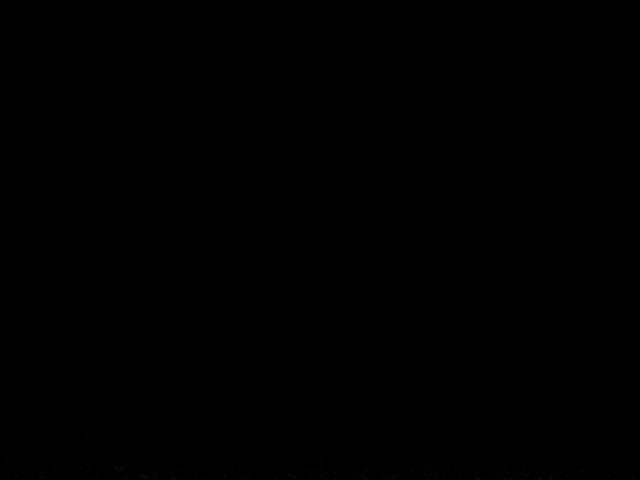

In [183]:
sqlfindimage()